# Introduction

**Members:** 

Alesandro Michael Ferdinand (101228984)

Bryan Austyn Ichsan (101229576)

Ng Jing Ping (101211418)


---



**Unit:** COS30082 - Applied Machine Learning



---





There are some concerns that need to be solved or fixed related to the training that have been done using the base model and the pre-trained model just then. The main concern from the training process is the data itself as there are some species that do not have any field image and the difference between the number of herbarium data and field data is also quite big. Working with this kind of data might need extra attention as the performance might be good on the species that have more images and the species that have field image on the dataset. The model might perform poor on the species that have 'incomplete' data.


In order to solve this issue, the main idea that the team tried on this notebook is to utilize Generative Model (CycleGAN) in order to generate the 'mocked field data' for classes that do not have the field data by utilzing the characteristic of the herbarium image that can be sensed by the Generative Model itself. It is expected that generating field images by using the knowledge of the herbarium images can give the model a slight boost of performance along with solving the issue of classes without field data and classes with few images only, simply by generating more images using Generative Model.

# Loading Data

Before we look at the model, we will need to load the data first. Start from importing or installing the required libraries.

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lbyi98gv
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-lbyi98gv


In [2]:
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix # We will use pix2pix pre-trained model to be our CycleGAN base model
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc

In [3]:
# We also need to connect this notebook with our Google Drive to store and load the required files
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# Let's extract the required data to colab so it is easier and faster to be accessed
!unzip drive/MyDrive/AML_project/train.zip > /dev/null
!unzip drive/MyDrive/AML_project/test.zip > /dev/null

!cp "/content/drive/MyDrive/AML_project/list/train.txt" "train.txt"
!cp "/content/drive/MyDrive/AML_project/list/groundtruth.txt" "groundtruth.txt"
!cp "/content/drive/MyDrive/AML_project/list/class_with_pairs.txt" "class_with_pairs.txt"

In [3]:
# There are also some constant that we might need to use for this notebook thus to ensure that the whole training or testing process
# will use the same constant for fair comparison, we will define those constant here in advance.
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 10
EPOCHS = 5

# We might also need to define th optimizer that we will use for the training process so let's take ADAM as our optimizer
generator_herbarium_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_field_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_herbarium_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_field_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# For the GAN loss itself, we will use binary crossentropy
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [4]:
# The data might differ a lot in term of range thus we need to normalize the data to prevent the model from being bias
def normalize_data(_image):
  image_data = tf.cast(_image, tf.float32)
  image_data = (image_data / 127.5) - 1
  return image_data

In [5]:
# Taking the paths of images that wanted to be load, load it as numpy array the pre-process it before returned.
def convert_image_to_numpy(image_paths_arr):
  dataset_nparr = list()

  for path in image_paths_arr:
    image_data = image.imread(path)

    image_data = tf.image.resize(image_data, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image_data = tf.image.random_crop(image_data, size=[IMG_WIDTH, IMG_HEIGHT, 3])
    image_data = tf.image.random_flip_left_right(image_data)

    image_data = normalize_data(image_data)
    dataset_nparr.append(image_data)

  return np.array(dataset_nparr)

In [6]:
# As the classess are represented in set of numbers, we might need to encode the classess to start from 0 thus preventing the
# model from assuming that there are more than 100 number of classess because of the raw labels.

def encode_labels(labels_arr):
  label_encoder = LabelEncoder()
  return label_encoder.fit_transform(labels_arr)

In [7]:
# Split the txt file into path and labels, load the image using path and encode the labels.
def load_data(text_file):
  with open(text_file) as txt_file:
    # read the file, with format "path label"
    # e.g. train/photo/106023/1769.jpg 106023
    lines_arr = [line.strip() for line in txt_file.readlines()]

    # split the lines to image path and label
    image_paths = [line.split(' ')[0] for line in lines_arr]
    labels = [line.split(' ')[1] for line in lines_arr]

    x_data = convert_image_to_numpy(image_paths)
    y_data = encode_labels(labels)

    return x_data, y_data

In [8]:
# This function will load the herbarium and field data separately.
# Moreover, as the model require the herbarium data and the field data to have the same size,
# this function will limit the herbarium data to be loaded until 10 images in maximum for each species
def load_separated_data(text_file):
  with open(text_file) as txt_file:
    lines_arr = [line.strip() for line in txt_file.readlines()]

    natural_image_paths = []
    natural_labels = []

    herbarium_image_paths = []
    herbarium_labels = []

    label_memory = ''
    label_counter = 0

    for line in lines_arr:
      full_path, label = line.split(' ')
      photo_type = full_path.split('/')[1]

      if(photo_type == "photo"):
        natural_image_paths.append(full_path)
        natural_labels.append(label)
      else: # It will limit each class to have 10 images of herbarium in maximum
        if label == label_memory:
          if label_counter < 10:
            herbarium_image_paths.append(full_path)
            herbarium_labels.append(label)
            label_counter = label_counter + 1
        else:
          herbarium_image_paths.append(full_path)
          herbarium_labels.append(label)
          label_counter = 1
        label_memory = copy.deepcopy(label)

    x_natural = convert_image_to_numpy(natural_image_paths)
    y_natural = encode_labels(natural_labels)

    x_herbarium = convert_image_to_numpy(herbarium_image_paths)
    y_herbarium = encode_labels(herbarium_labels)

    return x_natural, y_natural, x_herbarium, y_herbarium

In [9]:
# In case that we want to load the whole data without any limitation on the number of herbarium images per class,
# this function will help us to do so in loading the data into 2 different set (herbarium and field).
def load_full_separated_data(text_file):
  with open(text_file) as txt_file:
    lines_arr = [line.strip() for line in txt_file.readlines()]

    natural_image_paths = []
    natural_labels = []

    herbarium_image_paths = []
    herbarium_labels = []

    for line in lines_arr:
      full_path, label = line.split(' ')
      photo_type = full_path.split('/')[1]

      if(photo_type == "photo"):
        natural_image_paths.append(full_path)
        natural_labels.append(label)
      else:
        herbarium_image_paths.append(full_path)
        herbarium_labels.append(label)

    x_natural = convert_image_to_numpy(natural_image_paths)
    y_natural = encode_labels(natural_labels)

    x_herbarium = convert_image_to_numpy(herbarium_image_paths)
    y_herbarium = encode_labels(herbarium_labels)

    return x_natural, y_natural, x_herbarium, y_herbarium

In [8]:
# Load the test dataset
x_test, y_test = load_data("groundtruth.txt")

In [13]:
# Load the train dataset, since this dataset will be used for CycleGAN training, we will limit the number of herbarium for each class
# to be adjusted according the number of field data.
x_field, y_field, x_herbarium, y_herbarium = load_separated_data("train.txt")

In [14]:
print("Shapes Checking (Filtered)")
print("X-natural: " + str(x_field.shape))
print("y-natural: " + str(y_field.shape))
print("X-herbarium: " + str(x_herbarium.shape))
print("y-herbarium: " + str(y_herbarium.shape))
print("X-test: " + str(x_test.shape))
print("y-test: " + str(y_test.shape))

Shapes Checking (Filtered)
X-natural: (1044, 256, 256, 3)
y-natural: (1044,)
X-herbarium: (1000, 256, 256, 3)
y-herbarium: (1000,)
X-test: (207, 256, 256, 3)
y-test: (207,)


According to the shape that we have printed above, we will work with around 1000 images with the size of 256x256 for both field and herbarium data while the test dataset has around 200 images also with the same size as the train set.

# CycleGAN

*Reference: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb#scrollTo=e1_Y75QXJS6h*

Generative Advesarial Network (GAN) as its name is a type of AI that can generate new data based on the knowledge that the model has whereby the generated data will be targeted to be as similar as possible to the knowledge that the model has. CycleGAN itself is also a type of GAN but it has the focus on the capturing the common characteristic of certain class or image then project it into the data that will be taken as the generated data even with the absence of paired training samples. Taken the sample from Tensorflow, we can utilize pix2pix model to help our data generation process with some modifications to add the cycle-consistent aspect to the training process. Cycle-Consistent training is the main highlight of CycleGAN which enable the training process without paired data.

## Testing Pix2Pix

Befor we start to train the CycleGAN, we can have a check first on how the pix2pix model perform without any Cycle-Consistent aspect been added into its training process as pix2pix itself is already a generative model.

In [23]:
# Load the generator and discrimator from pix2pix model.
# The concept of GAN will utilize generator to generate data then the generated data will be fit into discriminator
# to calculate the loss values and the other important metrics hence the evaluation values given by the discriminator can be
# back-propagated to the model to adjust the knowledge of the model. GAN will be taken as having good performance when the discriminator
# cannot discrimate which image is the generated one and which image is the real image.

OUTPUT_CHANNELS = 3

generator_herbarium = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_field = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_herbarium = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_field = pix2pix.discriminator(norm_type='instancenorm', target=False)

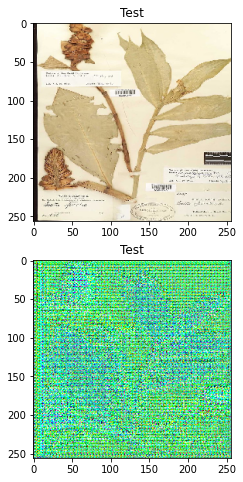

In [18]:
# Let's try to ask the pix2pix generator to generate the field image for the first 5 herbarium images
to_field = generator_field(x_herbarium[:5])

# As we need to evaluate the model subjectively, we will need to plot the image
plt.figure(figsize=(8, 8))
contrast = 8

# Plot the first herbarium image and the generated data for that herbarium image
for i in range(2):
  plt.subplot(2, 1, i+1)
  plt.title('Test')
  if(i == 0):
    plt.imshow(x_herbarium[0] * 0.5 + 0.5)
  else:
    plt.imshow(to_field[0] * 0.5 * contrast + 0.5)

plt.show()

As we can see on the generated data above, the generated image that has been generated by the pix2pix generator seems to be really abstract. We cannot use this kind of image for our training process as it will just harm the discriminative model later on as there are too many noises on the dataset. We will need to train the GAN to produce better quality of image thus Consistent-Cycle is applied.

## Training CycleGAN

As we want to train the GAN by also applying the Cycle-Consistent concept, we will need to prepare some loss functions in advance to help us in counting the loss of the model.

In [15]:
# In order to count the loss of the discrimator, we will count average loss of the real data and the predicted data
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [16]:
# Generator loss will directly use the loss value of the generated data
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [17]:
# Cycle-Consistent itself means that the difference between the real image and the image that has been generated using the same image
# should be as minimum as possible. Thus, cycle loss will count the loss between the cycled image and the real image.
# Cycled image itself is an image that has been generated by using a generator to generate the first image (Y') then the first image itself
# will be fed into the generator that will generate the image back to its real image state (X -> Y' -> X')

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

In [18]:
# Another loss that can be taken into consideration in making a more robust CycleGAN model is the identity loss.
# Asking herbarium generator to generate herbarium data should have produced the same image as the one been fed to the model.
# Identity Loss will ensure that the model will have this kind of robustness.

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [19]:
# We might need to check the quality of the generated image after the training process thus we can make a function that will help us
# to show the generated image for us to check.

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [26]:
# The training process will consume a lot of memory so we might need to cleanup some 'memory garbage' first.
gc.collect()

70

In [27]:
# This function will be used to train the CycleGAN with the mini-batch approach for a more efficient memory allocation.

# @tf.function
def train_step(real_herbarium_raw, real_field_raw):
  with tf.GradientTape(persistent=True) as tape:
    # Since we are using mini-batch, we will need to store the loss values of each mini-batch
    # before we count the average loss value for the batch that will be back-propagated later on
    total_gen_herbarium_loss = []
    total_gen_field_loss = []
    disc_herbarium_loss = []
    disc_field_loss = []

    # Taking 2 images per training (mini-batch) from each given batch
    tracker = 0
    iterator = 2

    # Iterate the whole batch
    while iterator <= real_herbarium_raw.shape[0]:
      # Take 2 images per iteration
      real_herbarium = real_herbarium_raw[tracker:iterator]
      real_field = real_field_raw[tracker:iterator]

      # Generate the fake field using herbarium and cycle the generated image back to herbarium
      fake_field = generator_field(real_herbarium, training=True)
      cycled_herbarium = generator_herbarium(fake_field, training=True)

      # Generate fake herbarium using field and cycle back the generated image to field
      fake_herbarium = generator_herbarium(real_field, training=True)
      cycled_field = generator_field(fake_herbarium, training=True)

      # Identity Generator
      same_herbarium = generator_herbarium(real_herbarium, training=True)
      same_field = generator_field(real_field, training=True)

      # Discriminators for real and generated images
      disc_real_herbarium = discriminator_herbarium(real_herbarium, training=True)
      disc_real_field = discriminator_field(real_field, training=True)

      disc_fake_herbarium = discriminator_herbarium(fake_herbarium, training=True)
      disc_fake_field = discriminator_field(fake_field, training=True)

      # Count the generator loss
      gen_herbarium_loss = generator_loss(disc_fake_herbarium)
      gen_field_loss = generator_loss(disc_fake_field)

      # Sum the cycle loss of both herbarium and field
      total_cycle_loss = calc_cycle_loss(real_herbarium, cycled_herbarium) + calc_cycle_loss(real_field, cycled_field)
      
      # Sum all lossess as the final generator loss and append it into the loss array
      total_gen_herbarium_loss_new = gen_herbarium_loss + total_cycle_loss + identity_loss(real_herbarium, same_herbarium)
      total_gen_field_loss_new = gen_field_loss + total_cycle_loss + identity_loss(real_field, same_field)

      total_gen_herbarium_loss.append(total_gen_herbarium_loss_new)
      total_gen_field_loss.append(total_gen_field_loss_new)

      # Count the discriminator loss and append it into the discriminator loss array
      disc_herbarium_loss_new = discriminator_loss(disc_real_herbarium, disc_fake_herbarium)
      disc_field_loss_new = discriminator_loss(disc_real_field, disc_fake_field)

      disc_herbarium_loss.append(disc_herbarium_loss_new)
      disc_field_loss.append(disc_field_loss_new)

      # Proceed to next mini-batch and clean the memory garbage
      print("Iteration: " + str(tracker) + ":" + str(iterator))

      tracker = iterator
      iterator = iterator + 2
      gc.collect

  # After iterating the whole batch, compute the gradients of the training process for both generator and discriminator
  generator_herbarium_gradients = tape.gradient(total_gen_herbarium_loss, 
                                        generator_herbarium.trainable_variables)
  generator_field_gradients = tape.gradient(total_gen_field_loss, 
                                        generator_field.trainable_variables)
  
  discriminator_herbarium_gradients = tape.gradient(disc_herbarium_loss, 
                                            discriminator_herbarium.trainable_variables)
  discriminator_field_gradients = tape.gradient(disc_field_loss, 
                                            discriminator_field.trainable_variables)
  
  # Apply the gradients to the optimizer to give the knowledge back to the model
  generator_herbarium_optimizer.apply_gradients(zip(generator_herbarium_gradients,
                                            generator_herbarium.trainable_variables))

  generator_field_optimizer.apply_gradients(zip(generator_field_gradients, 
                                            generator_field.trainable_variables))
  

  discriminator_herbarium_optimizer.apply_gradients(zip(discriminator_herbarium_gradients,
                                                discriminator_herbarium.trainable_variables))
  
  discriminator_field_optimizer.apply_gradients(zip(discriminator_field_gradients,
                                                discriminator_field.trainable_variables))

Epoch: 0
Current batch: 0:4
Iteration: 0:2
Iteration: 2:4
Current batch: 4:8
Iteration: 0:2
Iteration: 2:4
Current batch: 8:12
Iteration: 0:2
Iteration: 2:4
Current batch: 12:16
Iteration: 0:2
Iteration: 2:4
Current batch: 16:20
Iteration: 0:2
Iteration: 2:4
Current batch: 20:24
Iteration: 0:2
Iteration: 2:4
Current batch: 24:28
Iteration: 0:2
Iteration: 2:4
Current batch: 28:32
Iteration: 0:2
Iteration: 2:4
Current batch: 32:36
Iteration: 0:2
Iteration: 2:4
Current batch: 36:40
Iteration: 0:2
Iteration: 2:4
Current batch: 40:44
Iteration: 0:2
Iteration: 2:4
Current batch: 44:48
Iteration: 0:2
Iteration: 2:4
Current batch: 48:52
Iteration: 0:2
Iteration: 2:4
Current batch: 52:56
Iteration: 0:2
Iteration: 2:4
Current batch: 56:60
Iteration: 0:2
Iteration: 2:4
Current batch: 60:64
Iteration: 0:2
Iteration: 2:4
Current batch: 64:68
Iteration: 0:2
Iteration: 2:4
Current batch: 68:72
Iteration: 0:2
Iteration: 2:4
Current batch: 72:76
Iteration: 0:2
Iteration: 2:4
Current batch: 76:80
Iterat

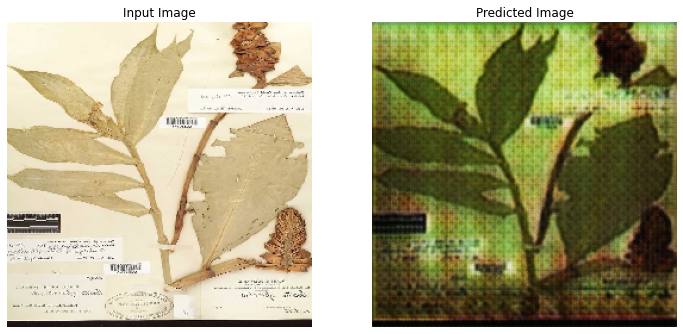

Epoch: 1
Current batch: 0:4
Iteration: 0:2
Iteration: 2:4
Current batch: 4:8
Iteration: 0:2
Iteration: 2:4
Current batch: 8:12
Iteration: 0:2
Iteration: 2:4
Current batch: 12:16
Iteration: 0:2
Iteration: 2:4
Current batch: 16:20
Iteration: 0:2
Iteration: 2:4
Current batch: 20:24
Iteration: 0:2
Iteration: 2:4
Current batch: 24:28
Iteration: 0:2
Iteration: 2:4
Current batch: 28:32
Iteration: 0:2
Iteration: 2:4
Current batch: 32:36
Iteration: 0:2
Iteration: 2:4
Current batch: 36:40
Iteration: 0:2
Iteration: 2:4
Current batch: 40:44
Iteration: 0:2
Iteration: 2:4
Current batch: 44:48
Iteration: 0:2
Iteration: 2:4
Current batch: 48:52
Iteration: 0:2
Iteration: 2:4
Current batch: 52:56
Iteration: 0:2
Iteration: 2:4
Current batch: 56:60
Iteration: 0:2
Iteration: 2:4
Current batch: 60:64
Iteration: 0:2
Iteration: 2:4
Current batch: 64:68
Iteration: 0:2
Iteration: 2:4
Current batch: 68:72
Iteration: 0:2
Iteration: 2:4
Current batch: 72:76
Iteration: 0:2
Iteration: 2:4
Current batch: 76:80
Iterat

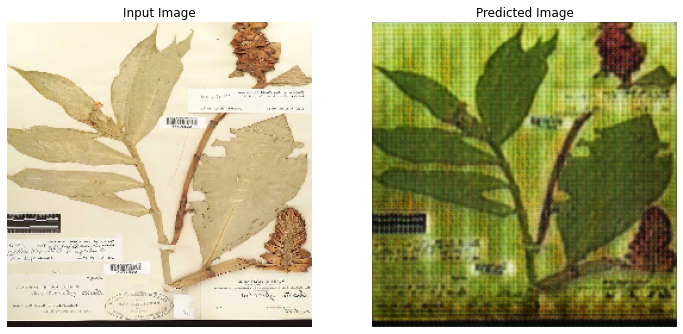

Epoch: 2
Current batch: 0:4
Iteration: 0:2
Iteration: 2:4
Current batch: 4:8
Iteration: 0:2
Iteration: 2:4
Current batch: 8:12
Iteration: 0:2
Iteration: 2:4
Current batch: 12:16
Iteration: 0:2
Iteration: 2:4
Current batch: 16:20
Iteration: 0:2
Iteration: 2:4
Current batch: 20:24
Iteration: 0:2
Iteration: 2:4
Current batch: 24:28
Iteration: 0:2
Iteration: 2:4
Current batch: 28:32
Iteration: 0:2
Iteration: 2:4
Current batch: 32:36
Iteration: 0:2
Iteration: 2:4
Current batch: 36:40
Iteration: 0:2
Iteration: 2:4
Current batch: 40:44
Iteration: 0:2
Iteration: 2:4
Current batch: 44:48
Iteration: 0:2
Iteration: 2:4
Current batch: 48:52
Iteration: 0:2
Iteration: 2:4
Current batch: 52:56
Iteration: 0:2
Iteration: 2:4
Current batch: 56:60
Iteration: 0:2
Iteration: 2:4
Current batch: 60:64
Iteration: 0:2
Iteration: 2:4
Current batch: 64:68
Iteration: 0:2
Iteration: 2:4
Current batch: 68:72
Iteration: 0:2
Iteration: 2:4
Current batch: 72:76
Iteration: 0:2
Iteration: 2:4
Current batch: 76:80
Iterat

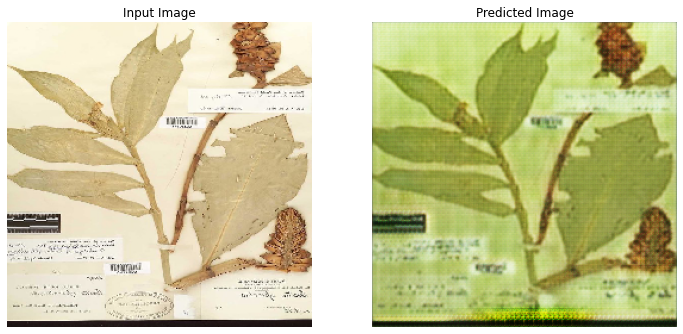

Epoch: 3
Current batch: 0:4
Iteration: 0:2
Iteration: 2:4
Current batch: 4:8
Iteration: 0:2
Iteration: 2:4
Current batch: 8:12
Iteration: 0:2
Iteration: 2:4
Current batch: 12:16
Iteration: 0:2
Iteration: 2:4
Current batch: 16:20
Iteration: 0:2
Iteration: 2:4
Current batch: 20:24
Iteration: 0:2
Iteration: 2:4
Current batch: 24:28
Iteration: 0:2
Iteration: 2:4
Current batch: 28:32
Iteration: 0:2
Iteration: 2:4
Current batch: 32:36
Iteration: 0:2
Iteration: 2:4
Current batch: 36:40
Iteration: 0:2
Iteration: 2:4
Current batch: 40:44
Iteration: 0:2
Iteration: 2:4
Current batch: 44:48
Iteration: 0:2
Iteration: 2:4
Current batch: 48:52
Iteration: 0:2
Iteration: 2:4
Current batch: 52:56
Iteration: 0:2
Iteration: 2:4
Current batch: 56:60
Iteration: 0:2
Iteration: 2:4
Current batch: 60:64
Iteration: 0:2
Iteration: 2:4
Current batch: 64:68
Iteration: 0:2
Iteration: 2:4
Current batch: 68:72
Iteration: 0:2
Iteration: 2:4
Current batch: 72:76
Iteration: 0:2
Iteration: 2:4
Current batch: 76:80
Iterat

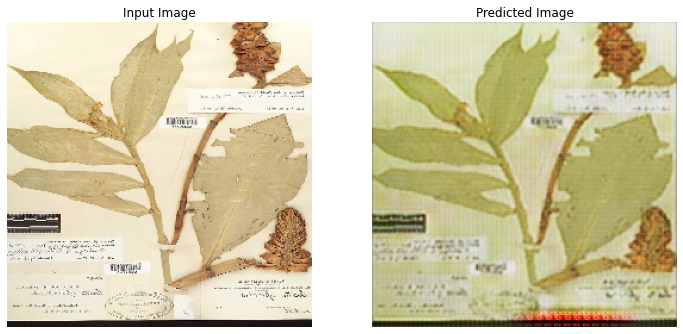

Epoch: 4
Current batch: 0:4
Iteration: 0:2
Iteration: 2:4
Current batch: 4:8
Iteration: 0:2
Iteration: 2:4
Current batch: 8:12
Iteration: 0:2
Iteration: 2:4
Current batch: 12:16
Iteration: 0:2
Iteration: 2:4
Current batch: 16:20
Iteration: 0:2
Iteration: 2:4
Current batch: 20:24
Iteration: 0:2
Iteration: 2:4
Current batch: 24:28
Iteration: 0:2
Iteration: 2:4
Current batch: 28:32
Iteration: 0:2
Iteration: 2:4
Current batch: 32:36
Iteration: 0:2
Iteration: 2:4
Current batch: 36:40
Iteration: 0:2
Iteration: 2:4
Current batch: 40:44
Iteration: 0:2
Iteration: 2:4
Current batch: 44:48
Iteration: 0:2
Iteration: 2:4
Current batch: 48:52
Iteration: 0:2
Iteration: 2:4
Current batch: 52:56
Iteration: 0:2
Iteration: 2:4
Current batch: 56:60
Iteration: 0:2
Iteration: 2:4
Current batch: 60:64
Iteration: 0:2
Iteration: 2:4
Current batch: 64:68
Iteration: 0:2
Iteration: 2:4
Current batch: 68:72
Iteration: 0:2
Iteration: 2:4
Current batch: 72:76
Iteration: 0:2
Iteration: 2:4
Current batch: 76:80
Iterat

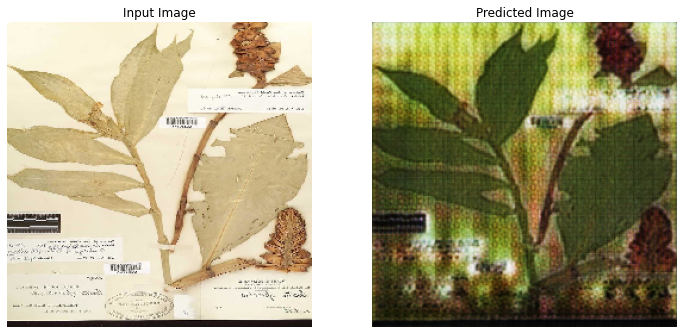

In [28]:
# We can train the model with some epochs
for epoch in range(EPOCHS):
  print("Epoch: " + str(epoch))

  # Take 4 images for each epoch
  tracker = 0
  batch_iterator = 4
  gc.collect()

  # Iterate the whole training dataset and train the model
  while batch_iterator <= x_herbarium.shape[0]:
    print("Current batch: " + str(tracker) + ":" + str(batch_iterator))
    train_step(x_herbarium[tracker:batch_iterator], x_field[tracker:batch_iterator])
    gc.collect()
    tracker = copy.deepcopy(batch_iterator)
    batch_iterator = copy.deepcopy(batch_iterator) + 4

    # Print the generated image sample for each epoch
    if batch_iterator > x_herbarium.shape[0]:
      generate_images(generator_field, x_herbarium[:2])

# Generating and Saving Data

After the CycleGAN model has been trained, we will then start to generate data using the trained model in order to augment the data by generating the missing field data based on its herbarium information.

In [11]:
# First, we will need to load the train dataset separately, but now we must not limit the number of herbarium
x_field_full, y_field_full, x_herbarium_full, y_herbarium_full = load_full_separated_data("train.txt")

Try to print out the shape. It seems like the number of herbarium is 2 times bigger than the number of field image. Moreover, not all classess are included inside of the field data as we can see that it only covers from label 0 to label 59.

In [35]:
x_field_full.shape

(1044, 256, 256, 3)

In [36]:
x_herbarium_full.shape

(3700, 256, 256, 3)

In [40]:
np.unique(y_field_full)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [18]:
# Since we need to have the herbarium image to generate the missing field data, we will need to look for the images
# that have the label of 60 onwards as the missing images are having the label of 60 until 99.
missing_images = []
missing_labels = []

for i in range(x_herbarium_full.shape[0]):
    if y_herbarium_full[i] >= 60:
      missing_images.append(x_herbarium_full[i])
      missing_labels.append(y_herbarium_full[i])

There are around 1,000 images with the label that we have targeted to extract (60-99)

In [54]:
len(missing_images)

1279

In [55]:
len(missing_labels)

1279

In [56]:
np.unique(missing_labels)

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99])

In [65]:
# Then we will need to ask the field generator to generate the field image for each herbarium images that have the targeted label
# We will generate 2 images in batch for preventing Out-of-Memory error.
# The result of the field generator will be in the form of numbers thus we will save those arrays into a single collective array.
predictions = []

tracker = 0
iterator = 2

while iterator <= len(missing_images):
  predictions.append(generator_field(np.array(missing_images[tracker:iterator])))
  tracker = copy.deepcopy(iterator)
  iterator = copy.deepcopy(iterator) + 2

In [66]:
# Cast the generation results to numpy for easier usage
predictions_np = np.array(predictions)

In [70]:
# As we are taking 2 images in the same time, the last image of the missing images was not fed into the field generator
# because of the odd total number of images. The shape of the predictions is also 5D so we will need to reshape the array into
# the expected shape to suit the shape of the other sets.
predictions_np_reshaped = predictions_np.reshape(len(missing_images)-1, 256, 256, 3)

As we can see, both the generated data and the full field data are 4D, containing images or arrays with the shape of 256x256. We have generated 1278 field images by using the CycleGAN approach.

In [27]:
predictions_np_reshaped.shape

(1278, 256, 256, 3)

In [26]:
x_field_full.shape

(1044, 256, 256, 3)

NOTE: It is better to save the data that we have generated in case that the session is disconnected so later on we can proceed without the need to generate the data anymore.

In [73]:
np.save('/content/drive/MyDrive/AML_project/generated_data.npy', predictions_np_reshaped)

In [19]:
# In case that it was disconnected, we can load the saved generated data simply by running this one line
predictions_np_reshaped = np.load('/content/drive/MyDrive/AML_project/generated_data.npy')

The generated data was supposed to fill the field dataset as the substitute for the missing field images, hence we need to append the generated data to the full field dataset to act as our complete augmented field data.

In [20]:
x_field_augmented = np.append(x_field_full, predictions_np_reshaped, axis=0)

We have around 1,000 of field images just then, but now with the augmented field data, we have made the gap of number of data between the field data and the herbarium data to be closer.

In [24]:
x_field_augmented.shape

(2322, 256, 256, 3)

In [25]:
x_herbarium_full.shape

(3700, 256, 256, 3)

We also need to do similar thing to the labels, but without data generation. We simply need to append the missing labels information to the field labels and reshape it a bit to have the same number of data as the augmented field set.

In [20]:
y_field_augmented = np.append(y_field_full, np.array(missing_labels), axis=0)
y_field_augmented = np.delete(y_field_augmented, -1)

In [19]:
y_field_augmented.shape

(2322,)

The field set that we took from the train set contains 60 labels only but with data generation using CycleGAN, now we have the complete set of 100 labels for the field set.

In [17]:
len(np.unique(y_field_full))

60

In [21]:
len(np.unique(y_field_augmented))

100

NOTE: Remember to save and load the data in case that the colab session crashed or disconnected

In [18]:
np.save('/content/drive/MyDrive/AML_project/x_field_augmented.npy', x_field_augmented)
np.save('/content/drive/MyDrive/AML_project/y_field_augmented.npy', y_field_augmented)

In [12]:
x_field_augmented = np.load('/content/drive/MyDrive/AML_project/x_field_augmented.npy', mmap_mode='r')
y_field_augmented = np.load('/content/drive/MyDrive/AML_project/y_field_augmented.npy')

In order to evaluate the impact of CycleGAN to the model that we have tested previously, we will need to mix the augmented field data with the full herbarium data as the augmented mix stream data using CycleGAN since the Neural Network that we have trained in advance were using mix stream data for fair comparison.

In [13]:
x_data_augmented = np.append(x_field_augmented, x_herbarium_full, axis=0)
y_data_augmented = np.append(y_field_augmented, y_herbarium_full, axis=0)

In [16]:
# Save the data in case the session crash
np.save('/content/drive/MyDrive/AML_project/x_data_augmented.npy', x_data_augmented)
np.save('/content/drive/MyDrive/AML_project/y_data_augmented.npy', y_data_augmented)

# Performance Comparison

In order to see how the model improves in term of performance before and after data augmentation using CycleGAN, we can simply evaluate one model with 2 different dataset, which are the normal one and the augmented one, to see how these 2 models differ in term of performance.

In [9]:
# Import the required libraries and initialize the required constant (number of classes) or function (top-5 accuracy)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy

In [10]:
def top_5_accuracy(y_true, y_pred):
  return sparse_top_k_categorical_accuracy (y_true, y_pred, k=5)

In [11]:
# First, we will need to load the data again just to make sure that the data was not modified by accident
# We will load the normal data using the train.txt and the augmented data using the numpy arrays that we have saved on our drive
x_data_pure, y_data_pure = load_data("train.txt")

In [12]:
x_data_augmented = np.load('/content/drive/MyDrive/AML_project/x_data_augmented.npy', mmap_mode='r')
y_data_augmented = np.load('/content/drive/MyDrive/AML_project/y_data_augmented.npy', mmap_mode='r')

In [13]:
nClasses = 100
batch_size = 32
steps_per_epoch_pure = int( np.ceil(x_data_pure.shape[0] / batch_size) )
steps_per_epoch_augmented = int( np.ceil(x_data_augmented.shape[0] / batch_size) )
initial_epochs = 32
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001)

In [20]:
# Make sure that both dataset have the same image shape (256x256) and the number of labels for each set is the same as the number of images of that set
print("Shape Checking")
print("Before GAN")
print("X-shape: " + str(x_data_pure.shape))
print("Y-shape: " + str(y_data_pure.shape))
print('\n')
print("After GAN")
print("X-shape: " + str(x_data_augmented.shape))
print("Y-shape: " + str(y_data_augmented.shape))

Shape Checking
Before GAN
X-shape: (4744, 256, 256, 3)
Y-shape: (4744,)


After GAN
X-shape: (6022, 256, 256, 3)
Y-shape: (6022,)


In [14]:
# Create Model
def createModel():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding = "same", kernel_regularizer=regularizers.L1(0.01), activation='relu', input_shape=(256, 256, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [22]:
# Call Create Model
cnn_model = createModel()

# Show model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 16)        0

In [15]:
# Show model's loss and accuracy graph
def plot_performance(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=[8,6])
  plt.plot(loss,'r',linewidth=3.0)
  plt.plot(val_loss,'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  plt.figure(figsize=[8,6])
  plt.plot(accuracy,'r',linewidth=3.0)
  plt.plot(val_accuracy,'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

In [23]:
# Train the model using normal dataset (no augmentation)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', top_5_accuracy])
history = cnn_model.fit(x_data_pure,
                        y_data_pure, 
                        batch_size=batch_size, 
                        steps_per_epoch=steps_per_epoch_pure,
                        epochs=initial_epochs, 
                        verbose=1, 
                        validation_data=(x_test, y_test))

Epoch 1/32
149/149 [==============================] - 33s 151ms/step - loss: 5.4146 - accuracy: 0.0076 - top_5_accuracy: 0.0403 - val_loss: 5.1534 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0531
Epoch 2/32
149/149 [==============================] - 21s 144ms/step - loss: 4.9996 - accuracy: 0.0097 - top_5_accuracy: 0.0487 - val_loss: 4.8803 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0725
Epoch 3/32
149/149 [==============================] - 21s 143ms/step - loss: 4.7945 - accuracy: 0.0084 - top_5_accuracy: 0.0449 - val_loss: 4.7470 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0580
Epoch 4/32
149/149 [==============================] - 21s 143ms/step - loss: 4.6938 - accuracy: 0.0072 - top_5_accuracy: 0.0422 - val_loss: 4.6821 - val_accuracy: 0.0048 - val_top_5_accuracy: 0.0628
Epoch 5/32
149/149 [==============================] - 21s 142ms/step - loss: 4.6473 - accuracy: 0.0061 - top_5_accuracy: 0.0441 - val_loss: 4.6521 - val_accuracy: 0.0097 - val_top_5_accuracy: 0.0483
Epoch

In [16]:
# Recompile the model and train it using the augmented data with CycleGAN
cnn_model = createModel()

In [17]:
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', top_5_accuracy])
history = cnn_model.fit(x_data_augmented,
                        y_data_augmented, 
                        batch_size=batch_size,
                        steps_per_epoch=steps_per_epoch_augmented,
                        epochs=initial_epochs, 
                        verbose=1, 
                        validation_data=(x_test, y_test))

Epoch 1/32
189/189 [==============================] - 40s 157ms/step - loss: 5.4780 - accuracy: 0.0103 - top_5_accuracy: 0.0518 - val_loss: 5.5031 - val_accuracy: 0.0193 - val_top_5_accuracy: 0.0531
Epoch 2/32
189/189 [==============================] - 28s 149ms/step - loss: 5.4504 - accuracy: 0.0171 - top_5_accuracy: 0.0825 - val_loss: 5.5217 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0435
Epoch 3/32
189/189 [==============================] - 28s 149ms/step - loss: 5.4276 - accuracy: 0.0221 - top_5_accuracy: 0.0942 - val_loss: 5.5485 - val_accuracy: 0.0193 - val_top_5_accuracy: 0.0386
Epoch 4/32
189/189 [==============================] - 28s 148ms/step - loss: 5.4044 - accuracy: 0.0276 - top_5_accuracy: 0.1147 - val_loss: 5.5818 - val_accuracy: 0.0097 - val_top_5_accuracy: 0.0435
Epoch 5/32
189/189 [==============================] - 28s 149ms/step - loss: 5.3798 - accuracy: 0.0322 - top_5_accuracy: 0.1224 - val_loss: 5.6207 - val_accuracy: 0.0097 - val_top_5_accuracy: 0.0435
Epoch

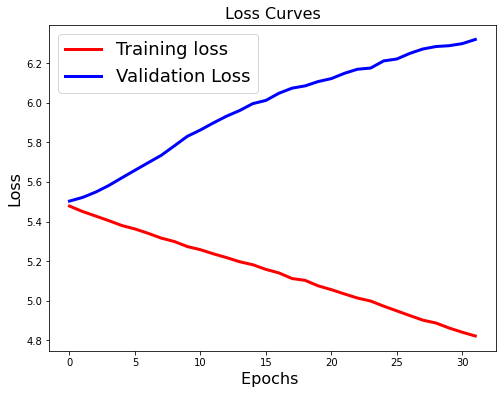

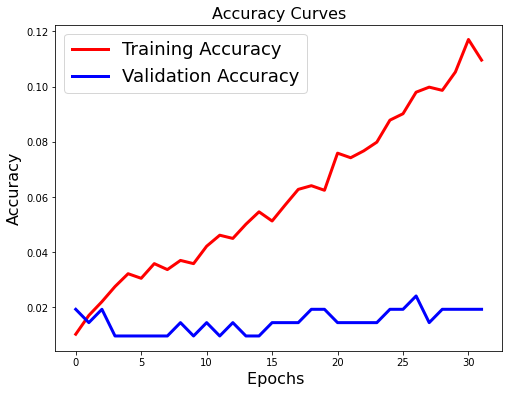

In [18]:
# Plot the performance of the CNN WITH data augmentation using CycleGAN
plot_performance(history)